# Camera Calibration and 3D Reconstruction

## Camera Calibration

### Goal

In this section,

* We will learn about distortions in camera, intrinsic and extrinsic parameters of camera etc.

### Basics

#### What is camera calibration?

For applications like object detection, we need to know what object is where. For that, we need to know camera properties and its parameters. For example, what are all the distortions in that camera? What is focal length of camera? What is optical center of camera lens? These information is intrinsic to that camera. We also need to know the position of camera in world co-ordinate system. These information is extrinsic to camera. So in short, we need to find the relation between points of 3D world and 2D image. Finding these intrinsic and extrinsic parameters of camera is called **camera calibration**.

#### Camera Types

There are various types of camera models available like pinhole camera model, fisheye camera model etc. Most popular one is pinhole camera model. It is simple. Once we get intrinsic parameters of camera, we can use it to correct the distortions in real time. 

#### Distortions

There are two types of distortions:

* Radial Distortion
* Tangential Distortion

##### Radial Distortion

Straight lines will appear curved in images. It is caused by the unequal scaling of axes. So once we know camera parameters, we can correct this distortion.

##### Tangential Distortion

It occurs because image taking lense is not aligned perfectly parallel to the imaging plane. So some areas in image may look nearer than expected.

#### Intrinsic Parameters

Intrinsic parameters are specific to a camera. It includes information like focal length $(f_x, f_y)$, optical centers $(c_x, c_y)$ etc. It is also called camera matrix. It depends on the camera only, so once calculated, it can be stored for future purposes. It is expressed as a 3x3 matrix:

$$
cameraMatrix = \begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

#### Extrinsic Parameters

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

So with the help of these parameters, we can find the 3D world coordinates of any point in that image if we know its coordinates in that image and vice-versa.

#### So what we do is

* We take 10-20 images of a chess board.
* We find some specific points in it ( square corners in chess board).
* We know its coordinates in real world space and we know its coordinates in image.
* With these data, some mathematical problem is solved in background to get the distortion coefficients, camera matrix etc. which are the intrinsic parameters of that camera.
* Now we can take an image, undistort it, use cv2.remap() to remap the pixels to canonical image and get a image without distortion.

### Code

We need at least 10 test patterns for camera calibration. We are using chess board as test pattern. The important input data needed for calibration of the camera is the set of 3D real world points and the corresponding 2D coordinates of these points in the image. 2D images points are OK which we can easily find from the image. (These image points are locations where two black squares touch each other in chess boards).  

What about the 3D points from real world space? Those images are taken from a static camera and chess boards are placed at different locations and orientations. So we need to know (X,Y,Z) values. But for simplicity, we can say chess board was kept stationary at XY plane, (so Z=0 always) and camera was moved accordingly. This consideration helps us to find only X,Y values. Now for X,Y values, we can simply pass the points as (0,0), (1,0), (2,0), ... which denotes the location of points. In this case, the results we get will be in the scale of size of chess board square. But if we know the square size, (say 30 mm), and we can pass the values as (0,0),(30,0),(60,0),..., we get the results in mm. (In this case, we don't know square size since we didn't take those images, so we pass in terms of square size).

3D points are called object points and 2D image points are called image points.

#### Setup

So to find pattern in chess board, we can use the function, cv2.findChessboardCorners(). We also need to pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use 7x6 grid. (Normally a chess board has 8x8 squares and 7x7 internal corners). It returns the corner points and retval which will be True if pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom)

##### Note
This function cannot find the chess board corners in all the images. So one good option is to write our own code so it starts the camera and check each frame for required pattern. If found, add to a list of found corners. Even if a failure happens in middle, we can take next image and continue the process. 

Instead of chess board, we can use some circular grid, but then use cv2.findCirclesGrid() to find the pattern. It is said that less number of images are enough when using circular grid.

Once we find the corners, we can increase their accuracy using cv2.cornerSubPix(). We can also draw the pattern using cv2.drawChessboardCorners().

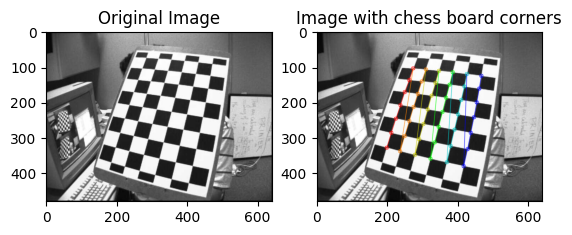

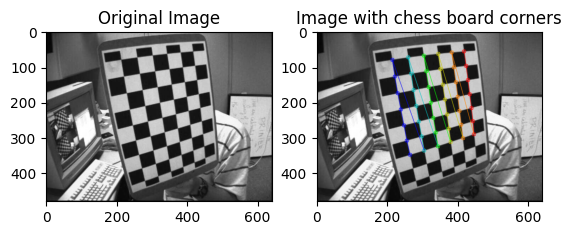

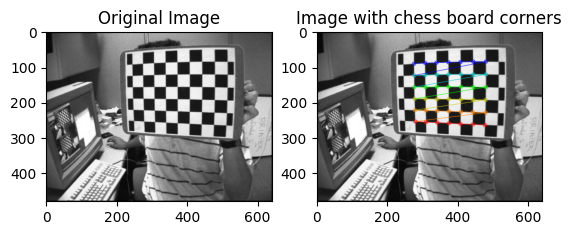

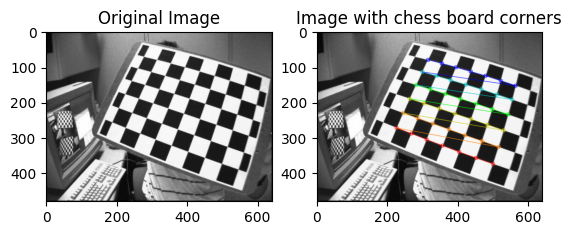

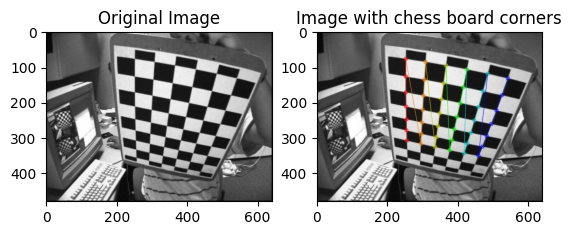

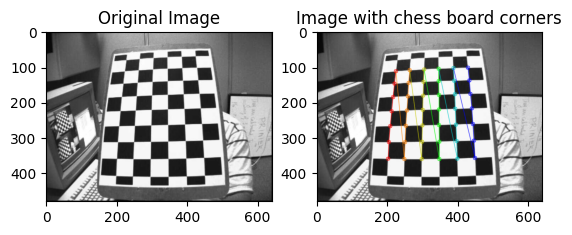

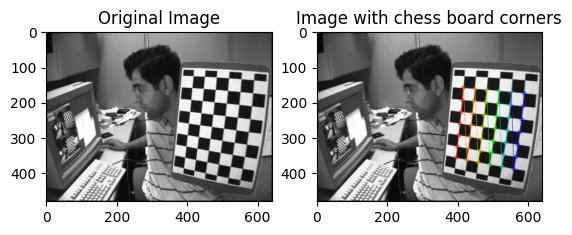

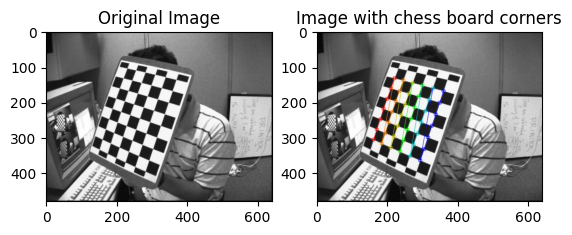

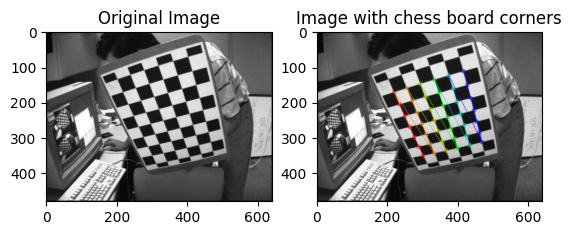

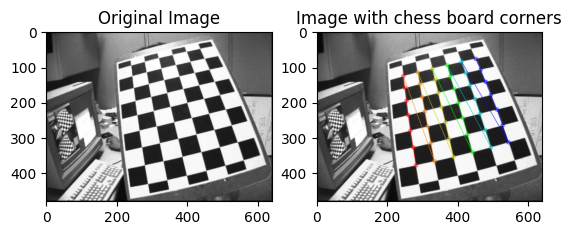

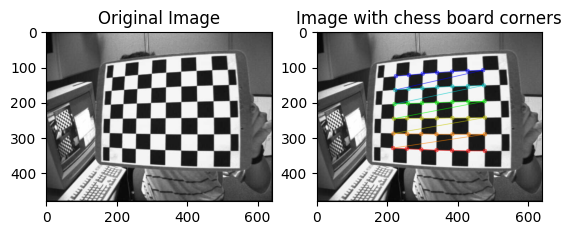

In [174]:
# data folder is obtained from opencv github repo
import numpy as np
import cv2 as cv
# to get the file pathnames
import glob
import matplotlib.pyplot as plt
# to save the camera matrix and distortion coefficients
import pickle

# termination criteria
# Criteria for termination of the iterative process of corner refinement.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
# 3d point in real world space
objpoints = []
# 2d points in image plane.
imgpoints = []
# Get all the file pathnames
images = glob.glob('data/left*.jpg')



for fname in images:
    # Read the image
    img = cv.imread(fname)
    # Convert to grayscale
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        # Add the object points
        objpoints.append(objp)
        # Refine the image points
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Add the image points
        imgpoints.append(corners2)
        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (7,6), corners2,ret)

        plt.subplot(121)
        plt.imshow(cv.cvtColor(cv.imread(fname), cv.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.subplot(122)
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title('Image with chess board corners')
        plt.show()


cv.destroyAllWindows()

#### Calibration

So now we have our object points and image points we are ready to go for calibration. For that we use the function, cv2.calibrateCamera(). It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [175]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Save the camera matrix and distortion coefficients for future use
data_pos = {'camera_matrix': mtx, 'dist_coeff': dist, 'rvecs': rvecs, 'tvecs': tvecs}


#### Undistortion

Now, we can take an image and undistort it. OpenCV comes with two methods, we will see both. But before that, we can refine the camera matrix based on a free scaling parameter using cv2.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.

So, we take a new image (left12.jpg)

In [176]:
img = cv.imread('data/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

1. Using cv2.undistort()
This is the easiest way. Just call the function and use ROI obtained above to crop the result.

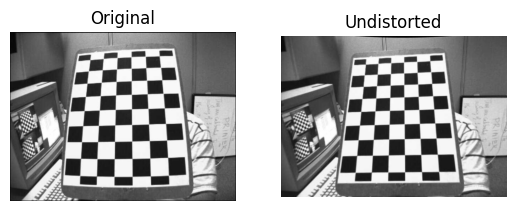

In [177]:
import matplotlib.pyplot as plt
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# Display the image
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(dst),plt.title('Undistorted')
plt.axis('off')
plt.show()


2. Using remapping

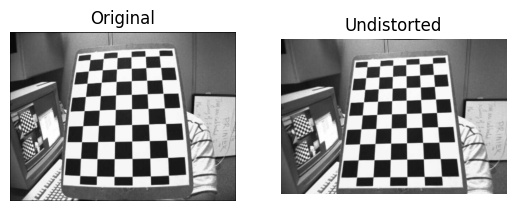

In [178]:
# undistort
mapx,mapy = cv.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv.remap(img,mapx,mapy,cv.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# Display the image
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(dst),plt.title('Undistorted')
plt.axis('off')
plt.show()

You can see the result in below image. Image is clearer at corners.

Now we can store the camera matrix and distortion coefficients using write functions in Numpy (np.savez, np.savetxt etc) for future uses.

#### Re-projection Error

Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. Given the intrinsic, distortion, rotation and translation matrices, we first transform the object point to image point using cv2.projectPoints(). Then we calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error we calculate the arithmetical mean of the errors calculate for all the calibration images.

In [179]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i],imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.023685996975391924


In [180]:
# circular grid distortion correction proposition (not working)
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
# Prepare grid points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
gridp = np.zeros((6*7,3), np.float32)
gridp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Get all the file pathnames
images = glob.glob('path/to/circular/grids') # circular grid images

for fname in images:
    # Read the image
    img = cv.imread(fname)
    # Convert to grayscale
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # Find the grid corners
    ret, corners = cv.findCirclesGrid(gray, (7,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        # Add the object points
        objpoints.append(gridp)
        # Refine the image points
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Add the image points
        imgpoints.append(corners2)
        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (7,6), corners2,ret)
        cv.imshow('img',img)
        cv.waitKey(500)

cv.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

img = cv.imread('data/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

import matplotlib.pyplot as plt
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

# Display the image
plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.axis('off')
plt.subplot(122),plt.imshow(dst),plt.title('Undistorted')
plt.axis('off')
plt.show()


error: OpenCV(4.8.1) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/calibration.cpp:3752: error: (-215:Assertion failed) nimages > 0 in function 'calibrateCameraRO'


## Pose Estimation

### Goal

In this section we will learn about pose estimation of fiducial markers like a circle board etc. We will see how to find these markers in an image and how to find their pose to do 3D pose estimation.

### Basics

During the previous section on camera callibration, we found the camera matrix, distortion coefficients etc. Given a pattern image, we can utilize the above information to calculate its pose, or how the object is situated in space, like how it is rotated, how it is displaced etc. For a planar object, we can assume Z=0, such that, the problem now becomes how camera is placed in space to see our pattern image. So, if we know how the object lies in the space, we can draw some 2D diagrams in it to simulate the 3D effect. We can draw a cube or anything else on the image using cv2.line() or cv2.drawContours() function.

#### What is pose?

Pose is the position and orientation of an object. So we need to find the translation and rotation vectors. Once we get them, we can find the location of the object in world co-ordinates, and draw some 3D axis to see the orientation of that object.


Our problem is, we want to draw our 3D coordinate axis (x, y, z axes) on our chessboard’s first corner. X axis in blue color, Y axis in green color and Z axis in red color. So in short, we have to find the following parameters:

First, let's load the camera matrix and distortion coefficients from the previous calibration result:



In [181]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

# load previously data

Now let's create a simple function to draw the coordinate axes from a given rotation and translation vector. We will draw the points using the cv2.line() function:

In [182]:
import cv2

def draw(img, corners, imgpts):
    corner = tuple(map(int, corners[0].ravel()))
    imgpt0 = tuple(map(int, imgpts[0].ravel()))
    imgpt1 = tuple(map(int, imgpts[1].ravel()))
    imgpt2 = tuple(map(int, imgpts[2].ravel()))
    
    img = cv.line(img, corner, imgpt0, (255, 0, 0), 5)
    img = cv.line(img, corner, imgpt1, (0, 255, 0), 5)
    img = cv.line(img, corner, imgpt2, (0, 0, 255), 5)
    
    return img

Then as in the previous case, we create termination criteria, object points (3D points of checkerboard corners in the world coordinate space) and axis points. We also load the image where we will draw the axis:

In [183]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

Now, we load the image, find the chessboard corners, and retreive the rotation and translation vectors using the cv2.solvePnP() function:

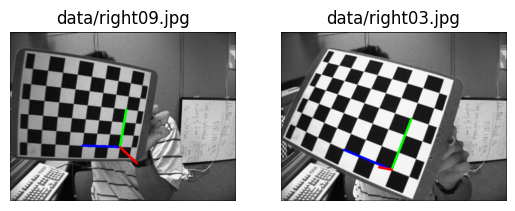

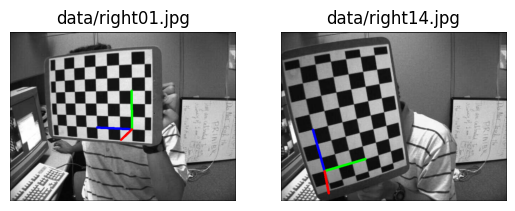

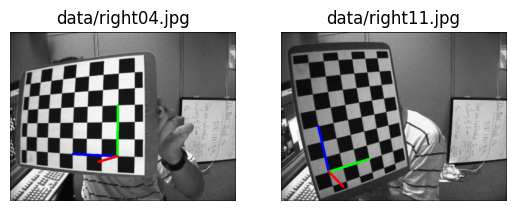

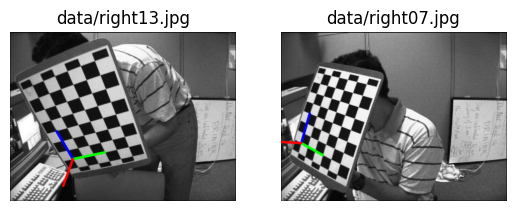

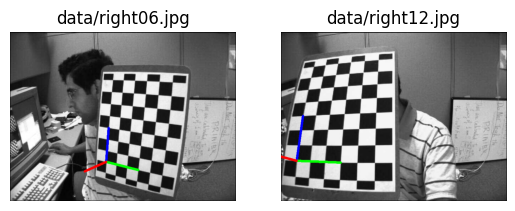

In [191]:
subplots = [1, 2, 1]
for fname in glob.glob('data/right*.jpg'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, rcvecs, tvecs = cv.solvePnP(objp, corners2, data_pos['camera_matrix'], data_pos['dist_coeff'])
        # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rcvecs, tvecs, data_pos['camera_matrix'], data_pos['dist_coeff'])

        img = draw(img,corners2,imgpts)

        plt.subplot(subplots[0], subplots[1], subplots[2])
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(fname)
        plt.axis('off')
        subplots[2] += 1
        if subplots[2] == 3:
            subplots[2] = 1
            subplots[1] += 1
        if subplots[1] == 3:
            subplots[1] = 2
            subplots[0] += 1
        if subplots[0] == 2:
            subplots[0] = 1
            plt.show()
            subplots = [1, 2, 1]

plt.show()

cv.destroyAllWindows()


#### Render the cube

Now we can render our cube using the cv2.projectPoints() function to project 3D points to the image plane given the rotation and translation vectors. We can draw the cube using the cv2.line() function:

In [195]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)

    # draw ground floor in green
    img = cv.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)

    # draw top layer in red color
    img = cv.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)

    return img


Modified axis points. They are 8 corners of cube in a 3D space

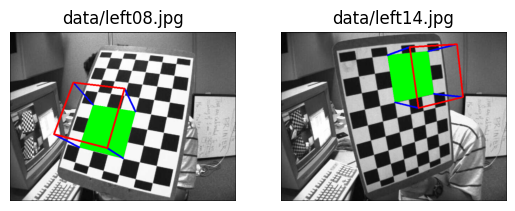

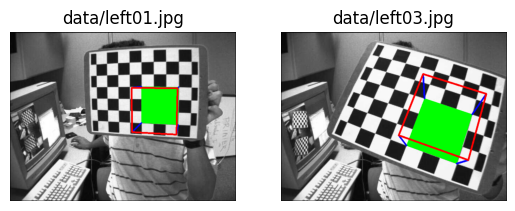

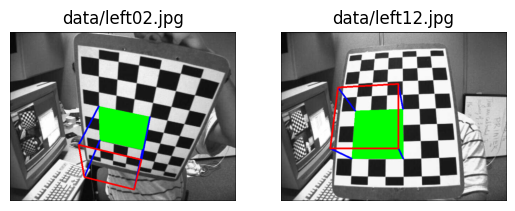

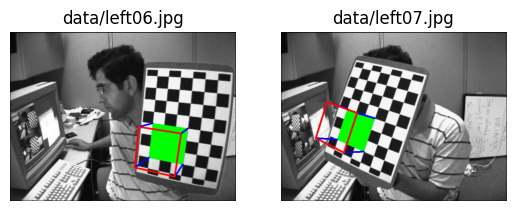

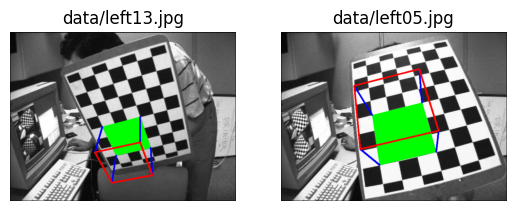

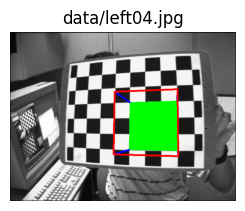

: 

In [196]:
axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0], 
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

subplots = [1, 2, 1]

for fname in glob.glob('data/left*.jpg'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret, rcvecs, tvecs = cv.solvePnP(objp, corners2, data_pos['camera_matrix'], data_pos['dist_coeff'])
        # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rcvecs, tvecs, data_pos['camera_matrix'], data_pos['dist_coeff'])

        img = draw(img,corners2,imgpts)

        plt.subplot(subplots[0], subplots[1], subplots[2])
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(fname)
        plt.axis('off')
        subplots[2] += 1
        if subplots[2] == 3:
            subplots[2] = 1
            subplots[1] += 1
        if subplots[1] == 3:
            subplots[1] = 2
            subplots[0] += 1
        if subplots[0] == 2:
            subplots[0] = 1
            plt.show()
            subplots = [1, 2, 1]

plt.show()


## Epipolar Geometry

### Goal

In this section, we will learn about the stereo imaging geometry. We will understand the epipolar geometry and its implementation.

### Basics

#### What is epipolar geometry?

Epipolar geometry is the intrinsic projective geometry between two views. It is a 3D analogy of planar perspective projection. In simple words, it describes the relationship between the two cameras in 3D space. It is defined by a 3×3 matrix called the **essential matrix**. It is a fundamental matrix in stereo vision which can be used to compute the epipolar lines in both images which converge to the corresponding point.

#### What is epipole?

The epipole is the point of intersection of the line through the camera centers and the image plane. It is the projection of the other camera center onto the image plane. The epipolar plane is the plane containing the baseline and the epipole.

#### What is epipolar line?

The epipolar line is the intersection of the epipolar plane with the image plane. It is the projection of the baseline onto the image plane. The epipolar constraint says that the epipolar lines in both images intersect at the corresponding points.

#### What is essential matrix?

The essential matrix is a 3×3 matrix which relates corresponding points in stereo images. It is defined up to a scale factor. It is used to compute the epipolar lines in both images which converge to the corresponding point.

#### What is fundamental matrix?

The fundamental matrix is a 3×3 matrix which relates corresponding points in stereo images. It is defined up to a scale factor. It is used to compute the epipolar lines in both images which converge to the corresponding point. It is a fundamental matrix in stereo vision which can be used to compute the epipolar lines in both images which converge to the corresponding point.

#### What is stereo correspondence?

Stereo correspondence is the process of finding corresponding points in stereo images. It is used to find the depth information from stereo images.

#### What is stereo matching?

Stereo matching is the process of finding corresponding points in stereo images. It is used to find the depth information from stereo images.

#### What is stereo vision?

Stereo vision is the process of recovering depth information from stereo images. It is based on the fact that objects in the world appear different from different viewpoints.

#### What is triangulation?

Triangulation is the process of finding the 3D position of a point given its projections onto two or more images. It is used to find the depth information from stereo images.

### Code

So now we know what is epipolar geometry and what are epipolar lines. We also know how to find the fundamental matrix and draw epipolar lines. So we can do stereo triangulation. For that, we need to find the corresponding points in both images. We can do it manually or using some feature detectors like SIFT, SURF etc. For simplicity, we will find it using SIFT descriptors. We will see how to find keypoints in one image and find the corresponding keypoints in other image. Once we get them, we can find the fundamental matrix. Then we can find the epilines. We draw the lines on both images. Along with that, we find the point on the second image corresponding to the point in first image. See the image below:

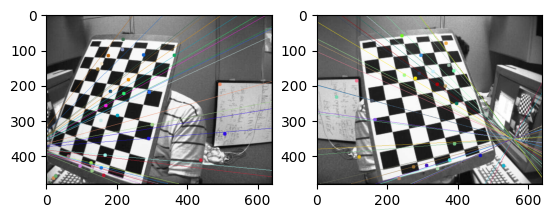

In [14]:
import numpy as np  
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('data/right08.jpg', cv2.IMREAD_GRAYSCALE) #queryimage # left image
# flipping the image
img2 = cv2.flip(cv2.imread('data/left08.jpg', cv2.IMREAD_GRAYSCALE), 1) #trainimage # right image
assert img1 is not None and img2 is not None

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None) # left image
kp2, des2 = sift.detectAndCompute(img2,None) # right image

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100) # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# now we have the list of best matches from both the images

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image
# lines corresponding to the points in second image is drawn on first image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist()) # RGB values
        x0,y0 = map(int, [0, -r[2]/r[1] ]) # starting point of the line
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ]) # ending point of the line
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1) # drawing the line on the first image
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1) # drawing the points on the first image
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1) # drawing the points on the second image
    return img1,img2

# Find epilines corresponding to points in right image (second image) and drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

You can see that the epilines are converging to the epipole point. The epipole point is the point of intersection of line joining two camera centers and the image plane. It is located on the image plane of the other camera.

## Depth Map from Stereo Images

### Goal

In this section, we will learn about stereo imaging and how to create 3D images. We will create depth map from stereo images. We will create these depth maps from stereo images.

### Basics

#### What is stereo imaging?

Stereo imaging is the process of creating 3D images from a pair of 2D images. It is based on the fact that objects in the world appear different from different viewpoints.

#### What is stereo vision?

Stereo vision is the process of recovering depth information from stereo images. It is based on the fact that objects in the world appear different from different viewpoints.

#### What is stereo correspondence?

Stereo correspondence is the process of finding corresponding points in stereo images. It is used to find the depth information from stereo images.

#### What is stereo matching?

Stereo matching is the process of finding corresponding points in stereo images. It is used to find the depth information from stereo images.

#### What is triangulation?

Triangulation is the process of finding the 3D position of a point given its projections onto two or more images. It is used to find the depth information from stereo images.

In summary we can say that stereo imaging is the process of recovering depth information from stereo images. It is based on the fact that objects in the world appear different from different viewpoints. Stereo correspondence is the process of finding corresponding points in stereo images. It is used to find the depth information from stereo images. Stereo matching is the process of finding corresponding points in stereo images. It is used to find the depth information from stereo images. Triangulation is the process of finding the 3D position of a point given its projections onto two or more images. It is used to find the depth information from stereo images.

### Code

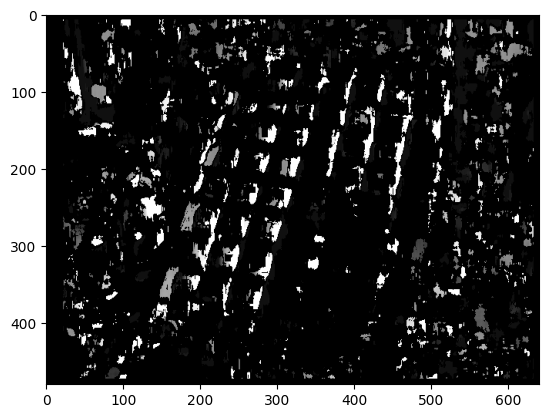

In [19]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('data/right08.jpg', cv.IMREAD_GRAYSCALE) #queryimage # left image
img2 = cv.imread('data/left08.jpg', cv.IMREAD_GRAYSCALE) #trainimage # right image

# Initiate stereoBM object with parameters
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img1,img2)
plt.imshow(disparity,'gray')
plt.show()

There are some parameters when you get familiar with stereo imaging. Those are:

* **texture_threshold** - minimum texture for a disparity hole
* **uniqueness_ratio** - margin in percentage by which the best candidate must "win" its second best match
* **speckle_size** - maximum size of smooth disparity regions to consider their noise speckles and invalidate
* **speckle_range** - maximum disparity variation within each connected component
* **number_of_disparities** - maximum disparity minus minimum disparity. Always greater than 0. divisible by 16
* **min_disparity** - minimum possible disparity value. Normally 0
* **prefilter_cap** - Truncation value for the prefiltered image pixels. Value is used for normalization before the pixel values are passed to the disparity algorithm. By default, normalization is not done if this value is less than or equal to zero. Otherwise, the normalization is done and the prefiltershift is subtracted from the pixel values
* **prefilter_size** - Gaussian blur window size. Must be odd. Normally it should be somewhere in the 3..11 range

